In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings
import optuna

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/test.csv', index_col='id')

In [4]:
feats_to_drop = [
    '_sort_6', '_cnt17', 'Deforestation', 'Watersheds', '_std', '_cnt1', '_cnt12', 
    '_cnt16', '_cnt8', '_sort_9', 'RiverManagement', 'Encroachments', '_30th', '_10th', 
    '_min', 'DrainageSystems', '_sort_7', '_40th', '_sort_5', 'PoliticalFactors', 
    'ClimateChange', '_mode', 'Landslides', 'TopographyDrainage', 'PopulationScore'
]
train = train.drop(columns=feats_to_drop)
test = test.drop(columns=feats_to_drop)

In [5]:
train.shape, test.shape

((1117957, 65), (745305, 64))

In [6]:
target_col = 'FloodProbability'

X = train.drop(target_col, axis=1)
y = train[target_col]

# Training

In [7]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 15,
    'max_leaves': 51,
    'n_estimators': 921,
    'random_state': SEED,
    'objective': 'reg:gamma',
    'grow_policy': 'depthwise',
    'gamma': 0.001191175583365525,
    'reg_alpha': 0.4922409840555407,
    'subsample': 0.9043911969552909,
    'reg_lambda': 0.2006103666827618,
    'max_delta_step': 0.5187236006765079,
    'learning_rate': 0.031068537109748533,
    'colsample_bynode': 0.9056076202576685,
    'min_child_weight': 0.1519636306480494,
    'colsample_bytree': 0.8136171314595549,
    'colsample_bylevel': 0.8469915838866402,
}

cb_params = {
    'depth': 10,
    'verbose': False,
    'iterations': 1566,
    'random_state': SEED,
    'min_data_in_leaf': 17,
    'loss_function': 'RMSE',
    'bootstrap_type': 'MVS',
    'grow_policy': 'SymmetricTree',
    'l2_leaf_reg': 1.6916966756596432,
    'learning_rate': 0.02548238769955287,
    'colsample_bylevel': 0.9626458989963868,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 34,
    'num_leaves': 171,
    'subsample_freq': 6,
    'n_estimators': 752,
    'random_state': SEED,
    'min_child_samples': 130,
    'subsample': 0.9350984753719289,
    'reg_alpha': 1.0394550805235323e-08,
    'reg_lambda': 4.033907925696443e-06,
    'learning_rate': 0.012066643395436406,
    'colsample_bytree': 0.7982322920102747,
    'min_child_weight': 0.002429931199773121
}

hgb_params = {
    "max_iter": 990,
    "max_depth": 8,
    "max_bins": 185,
    'random_state': SEED,
    "max_leaf_nodes": 183,
    "min_samples_leaf": 12,
    "learning_rate": 0.037434436270854445,
    "l2_regularization": 0.02286490401368979,
}

gb_params = {
    "max_depth": 9,
    "n_estimators": 369,
    'random_state': SEED,
    "alpha": 0.878238743008556,
    "subsample": 0.8110202065754267,
    "max_features": 0.3357955633913219,
    "learning_rate": 0.015631610015319746,
}

In [9]:
xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds = Trainer(xgb_model, X, y).fit()
print(f'{xgb_model.__class__.__name__}: {np.mean(xgb_scores):.6f} ± {np.std(xgb_scores):.6f}')

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds = Trainer(cb_model, X, y).fit()
print(f'{cb_model.__class__.__name__}: {np.mean(cb_scores):.6f} ± {np.std(cb_scores):.6f}')

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds = Trainer(lgbm_model, X, y).fit()
print(f'{lgbm_model.__class__.__name__}: {np.mean(lgbm_scores):.6f} ± {np.std(lgbm_scores):.6f}')

hgb_model = HistGradientBoostingRegressor(**hgb_params)
hgb_scores, hgb_oof_preds = Trainer(hgb_model, X, y).fit()
print(f'{hgb_model.__class__.__name__}: {np.mean(hgb_scores):.6f} ± {np.std(hgb_scores):.6f}')

# gb_model = GradientBoostingRegressor(**gb_params)
# gb_scores, gb_oof_preds = Trainer(gb_model, X, y).fit()
# print(f'{gb_model.__class__.__name__}: {np.mean(gb_scores):.6f} ± {np.std(gb_scores):.6f}')

XGBRegressor: 0.869192 ± 0.000379
CatBoostRegressor: 0.869156 ± 0.000386
LGBMRegressor: 0.869302 ± 0.000365
HistGradientBoostingRegressor: 0.869165 ± 0.000397


In [10]:
ridge_x = np.column_stack([
    xgb_oof_preds,
    cb_oof_preds, 
    lgbm_oof_preds,
    hgb_oof_preds, 
#     gb_oof_preds
])

scaler = StandardScaler()
ridge_x = pd.DataFrame(scaler.fit_transform(ridge_x))

ridge_model = Ridge(positive=True, tol=1e-6)
ridge_model.fit(ridge_x, y)
ridge_preds = ridge_model.predict(ridge_x)
ridge_score = r2_score(y, ridge_preds)
print(f'{ridge_model.__class__.__name__}: {ridge_score:.6f}')

Ridge: 0.869365


In [11]:
weights = pd.Series(
    ridge_model.coef_, 
    index=[
        "XGBRegressor",
        "CatBoostRegressor",
        "LGBMRegressor", 
        "HistGradientBoostingRegressor", 
#         "GradientBoostingRegressor"
    ]
)
weights

XGBRegressor                     0.001363
CatBoostRegressor                0.009053
LGBMRegressor                    0.023190
HistGradientBoostingRegressor    0.013974
dtype: float64

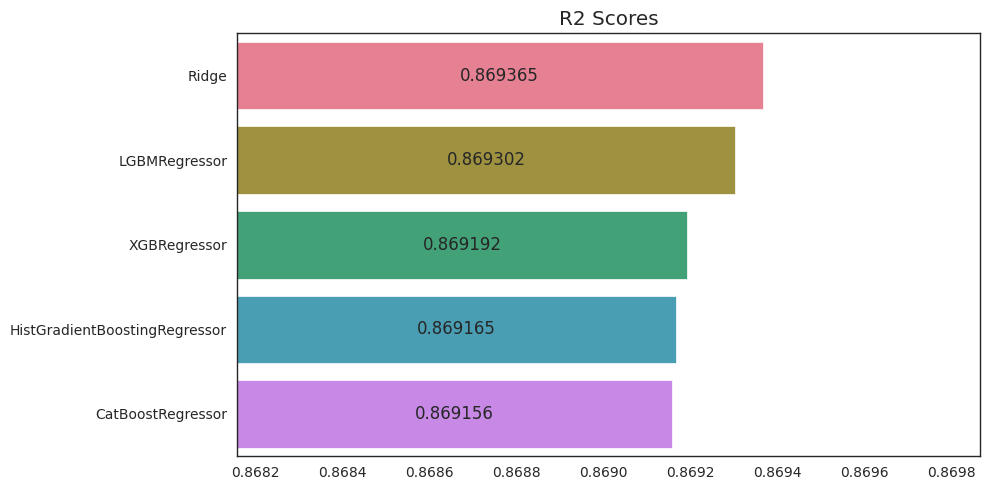

In [12]:
sns.set_style("white")
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    cb_model.__class__.__name__: cb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    hgb_model.__class__.__name__: hgb_scores,
#     gb_model.__class__.__name__: gb_scores,
    ridge_model.__class__.__name__: np.array([ridge_score] * 5)
})
scores = scores[scores.mean().sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')
ax.set_title('R2 Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.0005)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
model_preds = {
    xgb_model.__class__.__name__: xgb_oof_preds,
    cb_model.__class__.__name__: cb_oof_preds,
    lgbm_model.__class__.__name__: lgbm_oof_preds,
    hgb_model.__class__.__name__: hgb_oof_preds,
#     gb_model.__class__.__name__: gb_oof_preds,
    ridge_model.__class__.__name__: ridge_preds
}

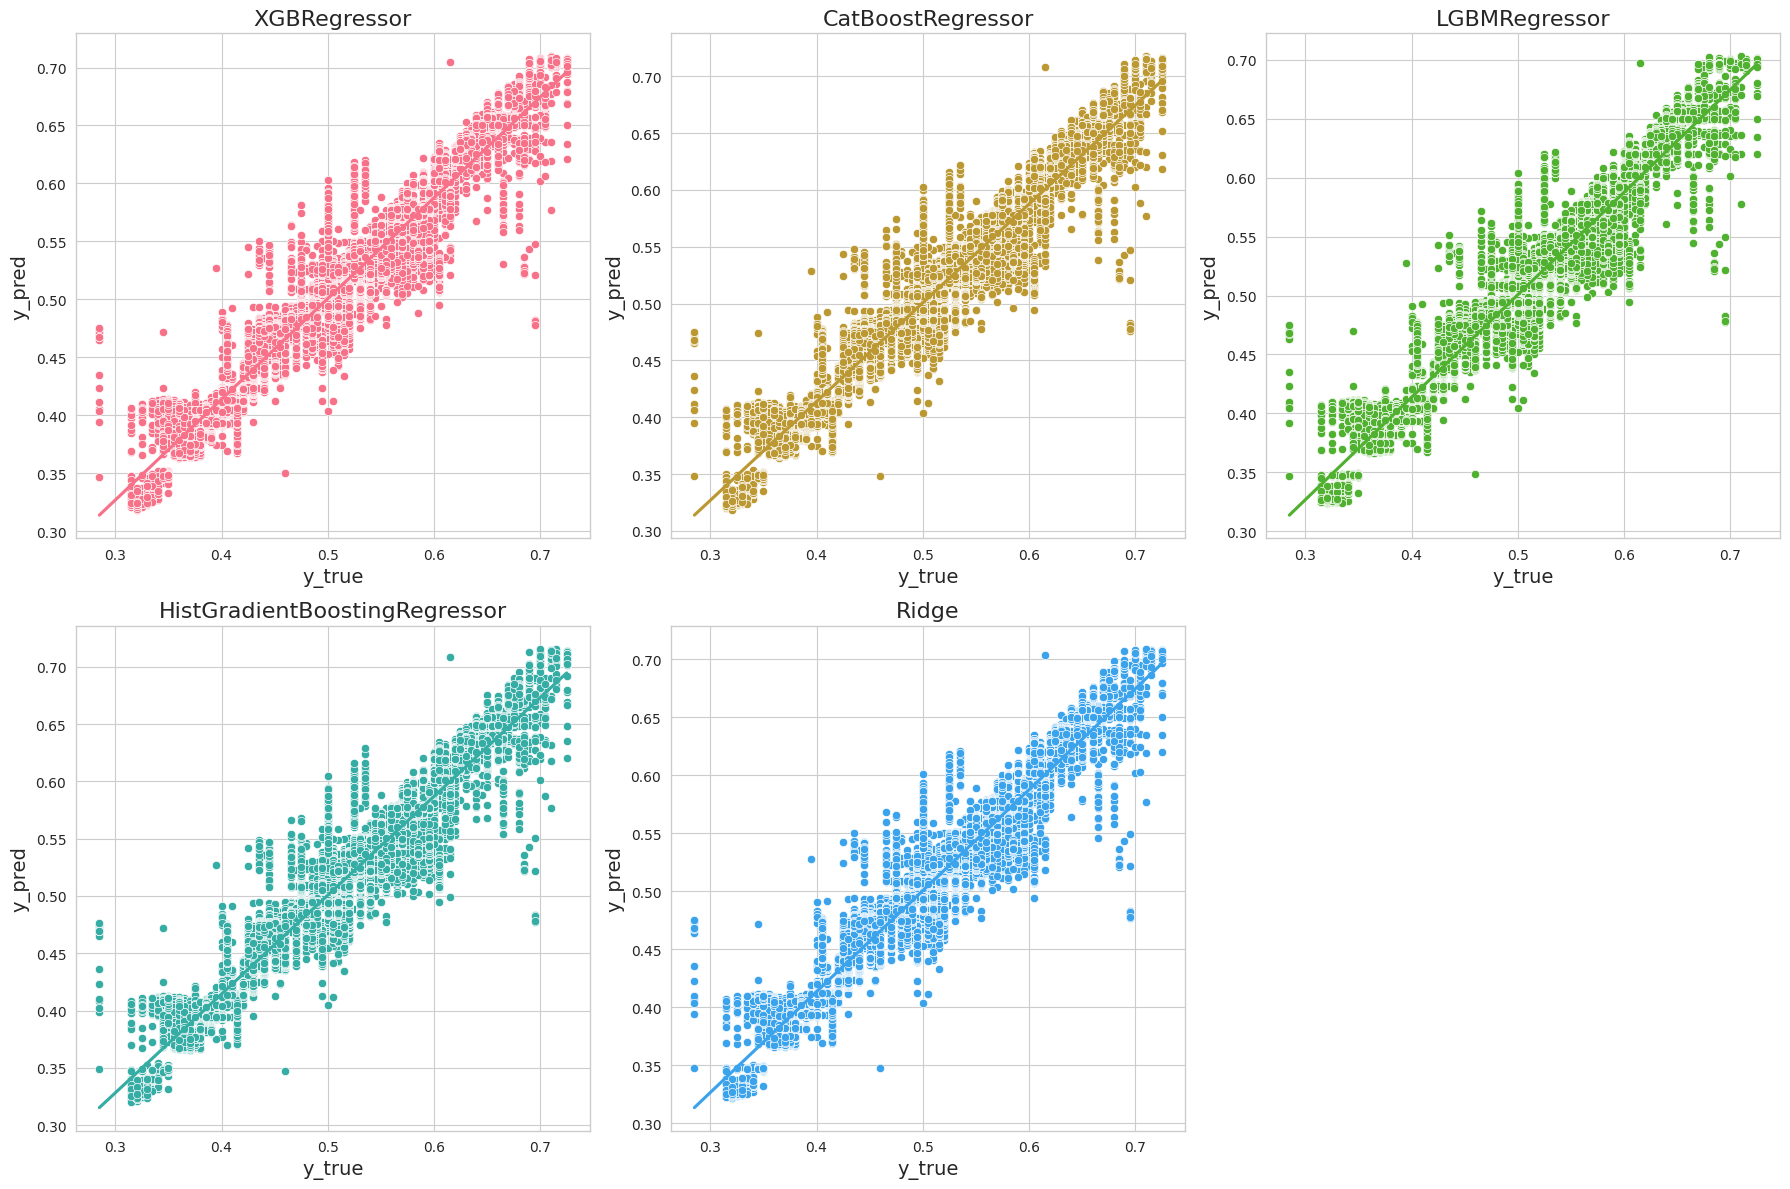

In [14]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.scatterplot(x=y, y=preds, ax=ax, color=sns.color_palette("husl")[i])
    sns.regplot(x=y, y=preds, ax=ax, scatter=False, color=sns.color_palette("husl")[i])
    
    ax.set_xlabel('y_true', fontsize=14)
    ax.set_ylabel('y_pred', fontsize=14)
    ax.set_title(model, fontsize=16)

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

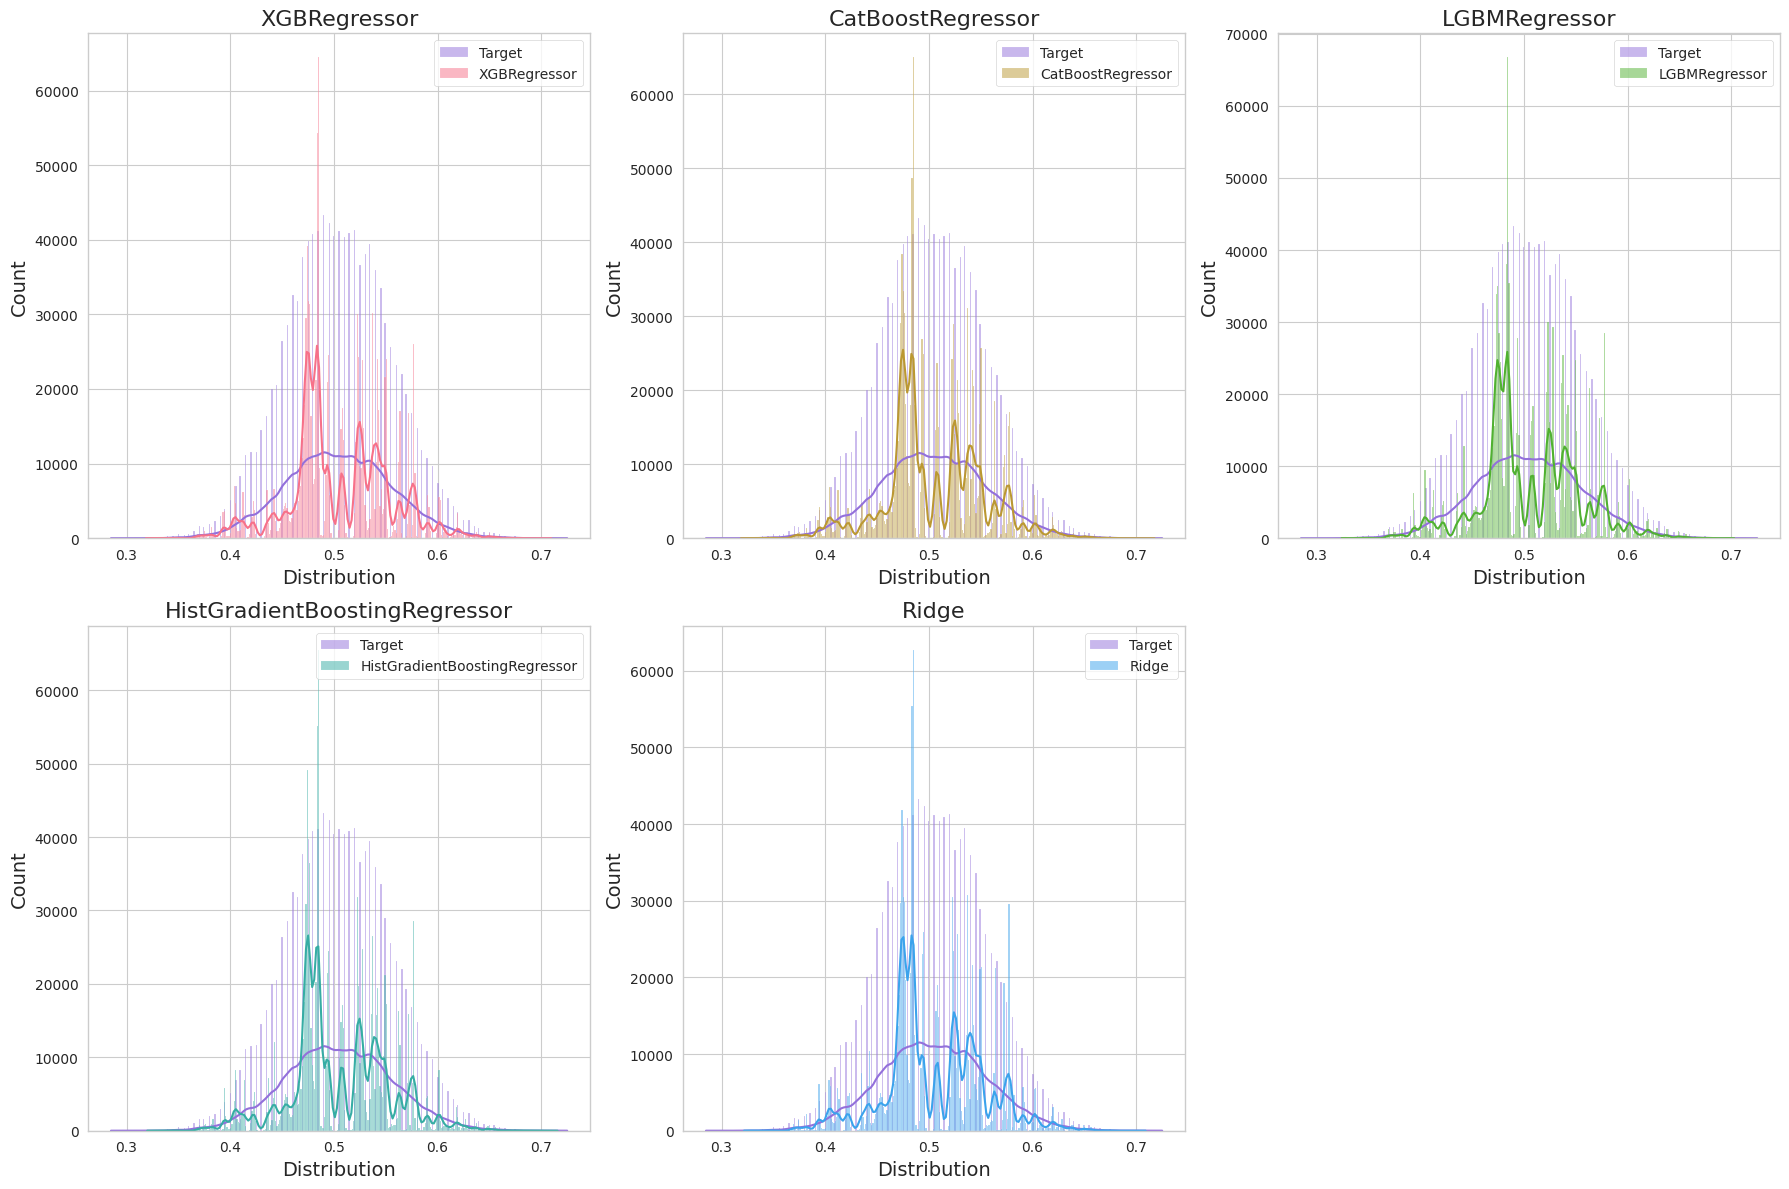

In [15]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.histplot(data=y, ax=ax, color='#9370DB', kde=True, legend=True, label="Target")
    sns.histplot(data=preds, ax=ax, color=sns.color_palette("husl")[i], kde=True, legend=True, label=model)
    
    ax.set_xlabel('Distribution', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(model, fontsize=16)
    ax.legend()

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Making Predictions

In [16]:
ridge_x_test = np.column_stack([
    Trainer(xgb_model, X, y).predict(test), 
    Trainer(cb_model, X, y).predict(test),
    Trainer(lgbm_model, X, y).predict(test), 
    Trainer(hgb_model, X, y).predict(test), 
#     Trainer(gb_model, X, y).predict(test), 
])
scaler = StandardScaler()
ridge_x_test = pd.DataFrame(scaler.fit_transform(ridge_x_test))

In [17]:
y_pred = ridge_model.predict(ridge_x_test)
submission = pd.DataFrame({'id': test.index, target_col: y_pred})
submission.to_csv(f'ensemble.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577944
1,1117958,0.456516
2,1117959,0.449047
3,1117960,0.466515
4,1117961,0.466100
